## W tym notebooku testuje Neural Network jako polityke wyboru kroku dla optymalizatora dOGR

In [1]:
import os

os.chdir("..")

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 2 eksperymentów ---

[1/2] Uruchamianie: dOGR_NN_politic


/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_NN_politic_vs_Adam/dOGR_NN_politic exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type  | Params | Mode 
---------------------------------------
0 | net  | LeNet | 61.7 K | train
---------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 215/215 [00:05<00:00, 40.97it/s, v_num=itic, train_loss=2.220]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 215/215 [00:05<00:00, 40.85it/s, v_num=itic, train_loss=2.220]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 54.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          18.93000030517578
        test_loss           2.2392616271972656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[2/2] Uruchamianie: Adam


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type  | Params | Mode 
---------------------------------------
0 | net  | LeNet | 61.7 K | train
---------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 215/215 [00:05<00:00, 38.38it/s, v_num=Adam, train_loss=0.0184] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 215/215 [00:05<00:00, 38.29it/s, v_num=Adam, train_loss=0.0184]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 57.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.7699966430664
        test_loss           0.0357956737279892
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Wszystkie eksperymenty zakończone ---

--- Generowanie wykresu porównawczego ---

--- Wyniki Końcowe ---

Wyniki dla 'dOGR_NN_politic':
  Końcowa Strata Testowa: 2.2393
  Końcowa Dokładność Testowa: 18.93%

Wyniki dla 'Adam':
  Końcowa Strata Testowa: 0.0358
  Końcowa Dokładność Testowa: 98.77%

Wykres porównawczy zapisano w: logs/dOGR_NN_politic_vs_Adam/final_comparison_log_scale_250epoch.png


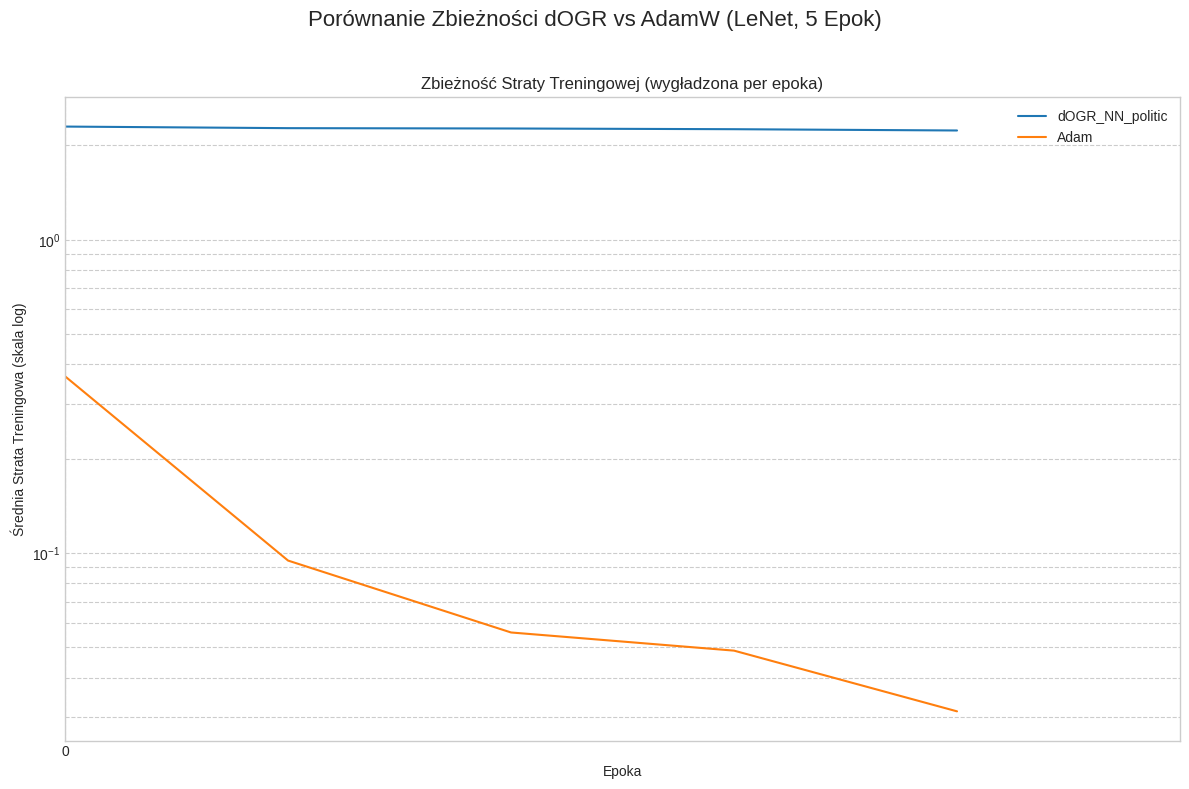

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import optim

# Ważne: Zakładam, że ten skrypt jest w tym samym folderze co 'main.py' i 'src'
from tests.main import run, net_dict
from src.optim.dOGR import dOGR
from tests.datamodule import MNISTDataModule
from src.optim.policy_net import PolicyNet

# --- Konfiguracja Eksperymentu ---
EXPERIMENT_NAME = "dOGR_NN_politic_vs_Adam"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 5
BATCH_SIZE = 256 # Używamy tego samego batch size co w Twoim skrypcie
NET = "LeNet"
LEARNING_RATE = 1e-3

# --- Definicja eksperymentów do porównania ---
experiments = {
    "dOGR_NN_politic": {
        "opt": dOGR,
        "args": {
            "nn_policy": True
        }
    },
    "Adam": {
        "opt": optim.Adam,
        "args": { "lr": LEARNING_RATE }
    }
}

def run_experiments():  
    """Uruchamia oba zdefiniowane eksperymenty."""
    print(f"--- Uruchamianie {len(experiments)} eksperymentów ---")
    for i, (version_name, config) in enumerate(experiments.items()):
        print(f"\n[{i+1}/{len(experiments)}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        net.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        optimizer = None

        if config["opt"] == dOGR:
            policy_net = PolicyNet(input_features=4, output_features=1)
            policy_net.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
            optimizer = dOGR(
                params=net.parameters(),
                policy_net=policy_net,
                policy_optimizer=policy_optimizer,
                net=net,
                lr=LEARNING_RATE,
                nn_policy=True
            )
        else:
            optimizer = optim.Adam(net.parameters(), **config["args"])

        datamodule = MNISTDataModule(batch_size=BATCH_SIZE)

        run(
            net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
            version=version_name, max_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, datamodule=datamodule
        )
    print("\n--- Wszystkie eksperymenty zakończone ---")

def plot_comparison():
    """Generuje jeden, ciągły wykres porównawczy dla straty treningowej."""
    print("\n--- Generowanie wykresu porównawczego ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    # --- ZMIANA: Tworzymy jeden wykres (fig, ax) zamiast dwóch (fig, axes) ---
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f"Porównanie Zbieżności dOGR vs AdamW ({NET}, {MAX_EPOCHS} Epok)", fontsize=16)

    print("\n--- Wyniki Końcowe ---")
    for name, config in experiments.items():
        # Poprawiona ścieżka, aby pasowała do logiki run_experiments
        if name == "dOGR_vs_AdamW_Comparison/dOGR_var_47.51":
            path = LOGGING_DIR / "dOGR_vs_AdamW_Comparison/dOGR_var_47.51" / "metrics.csv"
        else:
            path = LOGGING_DIR / EXPERIMENT_NAME / f"{name}" / "metrics.csv"
        if not path.exists():
            print(f"Nie znaleziono logów dla: {name}")
            continue
            
        df = pd.read_csv(path)
        
        train_loss_epoch = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()

        # --- ZMIANA: Rysujemy ciągłą linię bez markerów ('-') na jednym wykresie (ax) ---
        ax.plot(train_loss_epoch["epoch"], train_loss_epoch["train_loss"], "-", label=name)

        # Wydrukuj finalne wyniki testowe
        test_df = df[["test_loss", "test_accuracy"]].dropna()
        if not test_df.empty:
            final_test_results = test_df.iloc[-1]
            print(f"\nWyniki dla '{name}':")
            print(f"  Końcowa Strata Testowa: {final_test_results['test_loss']:.4f}")
            print(f"  Końcowa Dokładność Testowa: {final_test_results['test_accuracy']:.2f}%")

    # --- ZMIANA: Ustawienia dla pojedynczego wykresu ---
    ax.set_title("Zbieżność Straty Treningowej (wygładzona per epoka)")
    ax.set_xlabel("Epoka")
    ax.set_xlim([0, MAX_EPOCHS])
    ax.set_ylabel("Średnia Strata Treningowa (skala log)")
    ax.set_yscale('log') # Ustawienie skali logarytmicznej na osi Y
    ax.legend()
    ax.grid(True, which='both', linestyle="--")

    plt.xticks(range(0, MAX_EPOCHS, 20))
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    output_dir = LOGGING_DIR / EXPERIMENT_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_path = output_dir / "final_comparison_log_scale_250epoch.png"
    plt.savefig(plot_path)
    print(f"\nWykres porównawczy zapisano w: {plot_path}")
    
    plt.show()


if __name__ == "__main__":
    run_experiments()
    plot_comparison()